# Project: SkimLit📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstract easier.

The paper we're replicating (the source of the dataset we'll be using ) is available at:  https://arxiv.org/abs/1710.06071



And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251


## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-82b0126d-e9ee-177d-b51e-3165a373b482)


## Get the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can doso from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# !ls pubmed-rct

In [ ]:
# Check what files are in the PubMed_20k dataset
# !ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

In [ ]:
# Start our experiments using 20k datasets with numbers replaced by "@" sign
data_dir = "/content/drive/MyDrive/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# check all of the filenames in the directory 
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/drive/MyDrive/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/drive/MyDrive/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/drive/MyDrive/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data , it's time to becoe one with it.

And one of the best ways to become one with the data is to visualize

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines pof text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename ,"r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
test_lines = get_lines(data_dir + "test.txt")
test_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

 Let's think about how we want our data to look.

 How I think our data would be best represented..
 
    '''
    [{'line_number': 0,
    'target':'Background',
    'text':'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines':11}...]
    '''


Let's write a function which turns each of our datasets into the above format so that we can continue to prepare pur data for modelling

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a lsit of dictionaries of abstract line data.

  Takes in filename , reads it contents and sorts through each line ,
  extracting things like the target label , the text of the sentence,
  how many sentence are in the  current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list of abstract

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Check to see if the line is an ID line
       abstract_id = line
       abstract_lines = "" # reset the abstract line if the line is an ID
    elif line.isspace(): # check to see if line is a new line
       abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines


       # Iterate through each line in a single abstract and count them at the same time
       for abstract_line_number , abstract_line in enumerate(abstract_line_split):
         line_data = {} # Create an empty dictionary for each line
         target_text_split = abstract_line.split("\t") # Split the target label from the label
         line_data["target"] = target_text_split[0] # get the target label
         line_data["text"] = target_text_split[1].lower() # get target text and lower it
         line_data["line_number"] = abstract_line_number # What number line does the line appears in the text data
         line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there 
         abstract_samples.append(line_data)
    else: # if the above condition aren't fullfilled , the line contains a labelled sentence
      abstract_lines +=line
  return abstract_samples
      

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

CPU times: user 429 ms, sys: 93 ms, total: 522 ms
Wall time: 2.65 s


In [ ]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
test_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_lines': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_lines': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspart

In [ ]:
len(train_samples)

180040

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

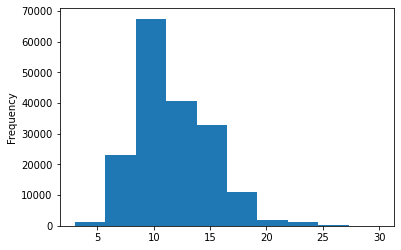

In [ ]:
# Let's check the lenght of different lines
train_df.total_lines.plot.hist()

### Get the lists of sentences


In [ ]:
# COnvert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
len(train_sentences)

180040

## Make numerice labels(ML models require labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape (-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [ ]:
# Extract labels (target columns) and encode these into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check the training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of  modelling experiment

## Model 0: Getting a basline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf",TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline model on validation dataset
model_0.score(X = val_sentences,y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from helper_function import calculate_results

In [ ]:
baseline_results = calculate_results(val_labels_encoded , baseline_preds )
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models , we've got to create vectorizerization and embedding layer

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# How long is each sentences on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
# sent_lens
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

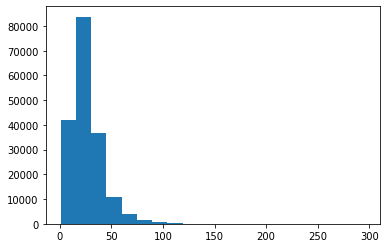

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins =20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len


55

In [ ]:
# Maximum seqence length in the training senteces
np.max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
# How many words are there in our vocab ?
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len) # desired output length of vectorized sequence

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence)}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")

Text:
both groups completed @ sessions .

Length of text:34

Vectorized text:[[ 54  24 253 416   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab:64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of our vocabulary
                               output_dim = 128 , # Note: different embedding sizes results in drastically different number of parameters to train
                               mask_zero = True ,# use masking to handle variable sequence lenghts
                               name = "token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization :\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape:{embedded_sentence.shape}")

Sentence before vectorization :
 both groups completed @ sessions .

Sentence after vectorization (before embedding):
 [[ 54  24 253 416   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
[[[ 0.03071738 -0.04481503  0.04337737 ...  0.03833764  0.04228416
   -0.0392325 ]
  [ 0.00907543 -0.03779256 -0.02799475 ... -0.00440376 -0.04991914
   -0.02870883]
  [ 0.01719966  0.01422707  0.02451538 ...  0.03662243  0.03923409
    0.0276573 ]
  ...
  [ 0.02391987 -0.01673996 -0.00233533 ... -0.0144444  -0.01709449
   -0.0166354 ]
  [ 0.02391987 -0.01673996 -0.00233533 ... -0.0144444  -0.01709449
   -0.0166354 ]
  [ 0.02391987 -0.01673996 -0.00233533 ... -0.0144444  -0.01709449
   -0.0166354 ]]]

Embedded sentence shape:(1, 55, 128)


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data as fast as possible with TensorFlow tf.data.API....

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
train_labels_one_hot.shape

(180040, 5)

In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take tehe TensorSliceDataset's and turn them into prefethed datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [ ]:
# Create 1D cov model to process sequences
inputs = layers.Input(shape = (1,),dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed (text_vectors)
x = layers.Conv1D(64,kernel_size = 5 , padding = "same",activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the ouput of our feature vector from conv layer
outputs = layers.Dense(num_classes,activation = "softmax")(x)
model_1 = tf.keras.Model(inputs , outputs)

# COmpile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Get the summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9213 - accuracy: 0.6350 - val_loss: 0.6904 - val_accuracy: 0.7390
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6603 - accuracy: 0.7535 - val_loss: 0.6354 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6188 - accuracy: 0.7746 - val_loss: 0.5987 - val_accuracy: 0.7862


In [ ]:
# Evaluate on while valid dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5999 - accuracy: 0.7855


[0.5999154448509216, 0.7855488061904907]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)

In [ ]:
model_1_pred_probs , model_1_pred_probs.shape

(array([[4.1493368e-01, 1.6759637e-01, 7.3631600e-02, 3.2396078e-01,
         1.9877626e-02],
        [4.5053637e-01, 2.6313958e-01, 1.2962571e-02, 2.6498207e-01,
         8.3793858e-03],
        [1.3806105e-01, 8.2043232e-03, 1.4200668e-03, 8.5229129e-01,
         2.3284441e-05],
        ...,
        [5.7182374e-06, 9.0454880e-04, 7.9602678e-04, 5.1596162e-06,
         9.9828857e-01],
        [5.9597213e-02, 4.6143964e-01, 9.8990761e-02, 7.3566750e-02,
         3.0640566e-01],
        [1.6837363e-01, 7.2140145e-01, 3.4960479e-02, 3.7620373e-02,
         3.7644163e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs ro classes
model_1_preds = tf.argmax(model_1_pred_probs ,axis = 1)

In [ ]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.55487885608368,
 'f1': 0.7833393220689411,
 'precision': 0.7825686057445608,
 'recall': 0.7855487885608368}

## Model 2: Feature extraction with pretrained token embedding

Now let's use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder(USE):
https://tfhub.dev/google/universal-sentence-encoder/4



In [ ]:
# Download pretrained TensorFLow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [ ]:
# Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")

Random sentence:
there were more maternal adverse effects of sublingual misoprostol ( p = @ ) .
Sentence after embedding:
[[ 3.90564539e-02 -4.37968150e-02  4.33983505e-02 -6.71131834e-02
  -3.36311609e-02 -3.11559550e-02  2.32949406e-02  1.28910141e-02
   1.05438922e-02  5.16323373e-02  8.79232287e-02  2.86890119e-02
   7.17808008e-02  6.80679679e-02 -3.80271138e-03 -3.56271677e-02
  -9.73896459e-02 -7.06327632e-02 -3.36555168e-02 -2.00115424e-02
   6.34635016e-02 -2.72110780e-03  2.72022909e-03 -2.42630597e-02
   3.55663523e-02  4.35117120e-03  4.90006134e-02 -8.47771298e-03
   1.11669973e-02  8.23688582e-02 -3.81249789e-04  9.57322791e-02
  -3.05545963e-02 -3.01095266e-02  1.67242344e-02  2.47728955e-02
   3.39937210e-02  3.74751426e-02  3.21462043e-02  1.31501835e-02
   9.16333869e-02  7.31015652e-02 -1.01096267e-02  8.00804496e-02
   4.07320708e-02  4.70499657e-02 -3.19355987e-02 -3.31771113e-02
   3.32422704e-02  3.61383222e-02 -2.74717491e-02 -3.97139117e-02
  -2.74730511e-02 -7

In [ ]:
tf.squeeze(use_embedded_sentence.shape)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([  1, 512], dtype=int32)>

### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# Define feature extraction model using Hub layers
inputs = layers.Input(shape = [],dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize and create embedding of each sequence(512 long vector)
x = layers.Dense(128,activation = "relu")(pretrained_embedding)
# extra layer can be added 
outputs = layers.Dense(num_classes,activation = "softmax")(x) # Output layer
model_2 = tf.keras.Model(inputs , outputs,name = "model_2_USE_feature_extractor")



# COmpile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model_2
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9186 - accuracy: 0.6483 - val_loss: 0.7966 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7679 - accuracy: 0.7026 - val_loss: 0.7551 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7503 - accuracy: 0.7132 - val_loss: 0.7369 - val_accuracy: 0.7138


In [ ]:
# Evaluate on the validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7392 - accuracy: 0.7145


[0.7391574382781982, 0.7144511938095093]

In [ ]:
# Make predictions on the valid data
model_2_pred_probs = model_2.predict(valid_dataset)

In [ ]:
model_2_pred_probs

array([[4.0978852e-01, 3.8030589e-01, 2.2466544e-03, 2.0012049e-01,
        7.5384327e-03],
       [3.5427168e-01, 4.8429134e-01, 4.2486843e-03, 1.5459216e-01,
        2.5960840e-03],
       [2.5012857e-01, 1.6257608e-01, 1.9049319e-02, 5.2880728e-01,
        3.9438773e-02],
       ...,
       [1.9871667e-03, 7.7190348e-03, 6.2017351e-02, 8.8566751e-04,
        9.2739081e-01],
       [4.2919978e-03, 4.4376533e-02, 2.0720914e-01, 1.6632576e-03,
        7.4245900e-01],
       [2.0225182e-01, 2.5906941e-01, 4.4908929e-01, 9.4952686e-03,
        8.0094166e-02]], dtype=float32)

In [ ]:
# COnvert the predictions probabilites found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)

In [ ]:
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embedding results on the val set
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.44512114391632,
 'f1': 0.7115647846354455,
 'precision': 0.7145510328187121,
 'recall': 0.7144512114391632}

## Model 3: Conv1D with character embedding

The paper which we're replicating states that they used combination of token and character embeddings.

Previously we've token-level embedding but we'll need to do similiar steps for characters if we want to use char-level embeddings

### Creating a charater level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into character
# split_chars(random_train_sentence)

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

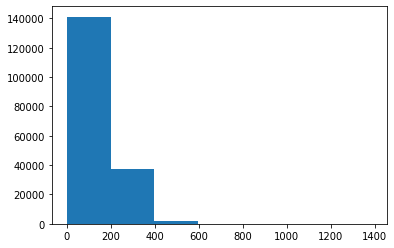

In [ ]:
# Check the distribution of our sequence at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins = 7);

In [ ]:
# Find what charater length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    # standardize = None, # set standardization to None if we want to leave punctuation in
                                    name = "char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vectorizer to train character
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different character in the character vocab:{len(char_vocab)}")
print(f"5 most coomon character :{char_vocab[:5]}")
print(f"5 least commom character: {char_vocab[-5:]} ")

Number of different character in the character vocab:28
5 most coomon character :['', '[UNK]', 'e', 't', 'i']
5 least commom character: ['k', 'x', 'z', 'q', 'j'] 


In [ ]:
# Test out the character vectorizer
random_train_chars = random.choice(train_chars)
print(f" Charified text:\n{random_train_chars}")
print(f"Length of random_train_chars:{len(random_train_chars.split())}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars:\n {len(vectorized_chars[0])}")

 Charified text:
i n c i d e n c e   o f   a d v e r s e   e v e n t s   w a s   r e l a t e d   t o   u n d e r l y i n g   d i s e a s e   ;   m a l a r i a   b e i n g   r e p o r t e d   i n   b o t h   t r e a t m e n t   a r m s   .
Length of random_train_chars:94

Vectorized chars:
[[ 4  6 11  4 10  2  6 11  2  7 17  5 10 21  2  8  9  2  2 21  2  6  3  9
  20  5  9  8  2 12  5  3  2 10  3  7 16  6 10  2  8 12 19  4  6 18 10  4
   9  2  5  9  2 15  5 12  5  8  4  5 22  2  4  6 18  8  2 14  7  8  3  2
  10  4  6 22  7  3 13  3  8  2  5  3 15  2  6  3  5  8 15  9  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embed")

In [ ]:
# Test our characte embedding layer
print(f"Charified text: \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars.(after vectorization):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text: 
i n c i d e n c e   o f   a d v e r s e   e v e n t s   w a s   r e l a t e d   t o   u n d e r l y i n g   d i s e a s e   ;   m a l a r i a   b e i n g   r e p o r t e d   i n   b o t h   t r e a t m e n t   a r m s   .

Embedded chars.(after vectorization):
 [[[-0.01724212  0.01176887 -0.01401349 ...  0.04560247 -0.02077821
   -0.0013475 ]
  [ 0.01346746  0.04566422  0.02050293 ...  0.01323769 -0.00030116
    0.01720801]
  [-0.02280462 -0.0442839   0.04630257 ...  0.00584733 -0.01018995
    0.01230564]
  ...
  [-0.04291065 -0.01485316 -0.02636116 ... -0.03281172 -0.01605765
   -0.02003236]
  [-0.04291065 -0.01485316 -0.02636116 ... -0.03281172 -0.01605765
   -0.02003236]
  [-0.04291065 -0.01485316 -0.02636116 ... -0.03281172 -0.01605765
   -0.02003236]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D to fit the character embedding

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1,),dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64,kernel_size = 5 , padding= "same",activation = "relu")(char_embeddings)
x= layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)
model_3 = tf.keras.Model(inputs ,outputs,name = "model_3_conv1d_char_embeddings")

# COmpile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Get the summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                             epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2539 - accuracy: 0.4905 - val_loss: 1.0479 - val_accuracy: 0.5808
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0010 - accuracy: 0.5996 - val_loss: 0.9417 - val_accuracy: 0.6250
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9199 - accuracy: 0.6448 - val_loss: 0.8720 - val_accuracy: 0.6636


In [ ]:
# Make predictions with the character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs


array([[0.18172131, 0.32230973, 0.1421404 , 0.3001852 , 0.05364335],
       [0.29993305, 0.44654146, 0.00688627, 0.22552124, 0.02111799],
       [0.1304034 , 0.24597624, 0.11321782, 0.4786813 , 0.03172121],
       ...,
       [0.01386974, 0.0388517 , 0.06661125, 0.02425321, 0.85641414],
       [0.03571367, 0.21331228, 0.33248752, 0.07753335, 0.34095317],
       [0.43286967, 0.44532555, 0.06091786, 0.04212606, 0.01876093]],
      dtype=float32)

In [ ]:
# Convert prediction probabiblities to class labels
model_3_preds = tf.argmax(model_3_pred_probs,axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate the reults
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)

In [ ]:
model_3_results

{'accuracy': 66.23196081027406,
 'f1': 0.6525660364289612,
 'precision': 0.6550082658227016,
 'recall': 0.6623196081027406}

## Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding layers)

1. Create a token-level embedding (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification)
3. Combine 1 & 2 with  a concatenate ('layers.Concatenate')
4. Build a series of output layers on the top.
5. Construct a model which takes token and character-level sequence as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape = [],dtype = tf.string , name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs , 
                             outputs = token_outputs)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM
char_model = tf.keras.Model(inputs = char_inputs , 
                            outputs = char_bi_lstm)


# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs = output_layer,
                         name = "model_4")

In [ ]:
# Get the summary of the model
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

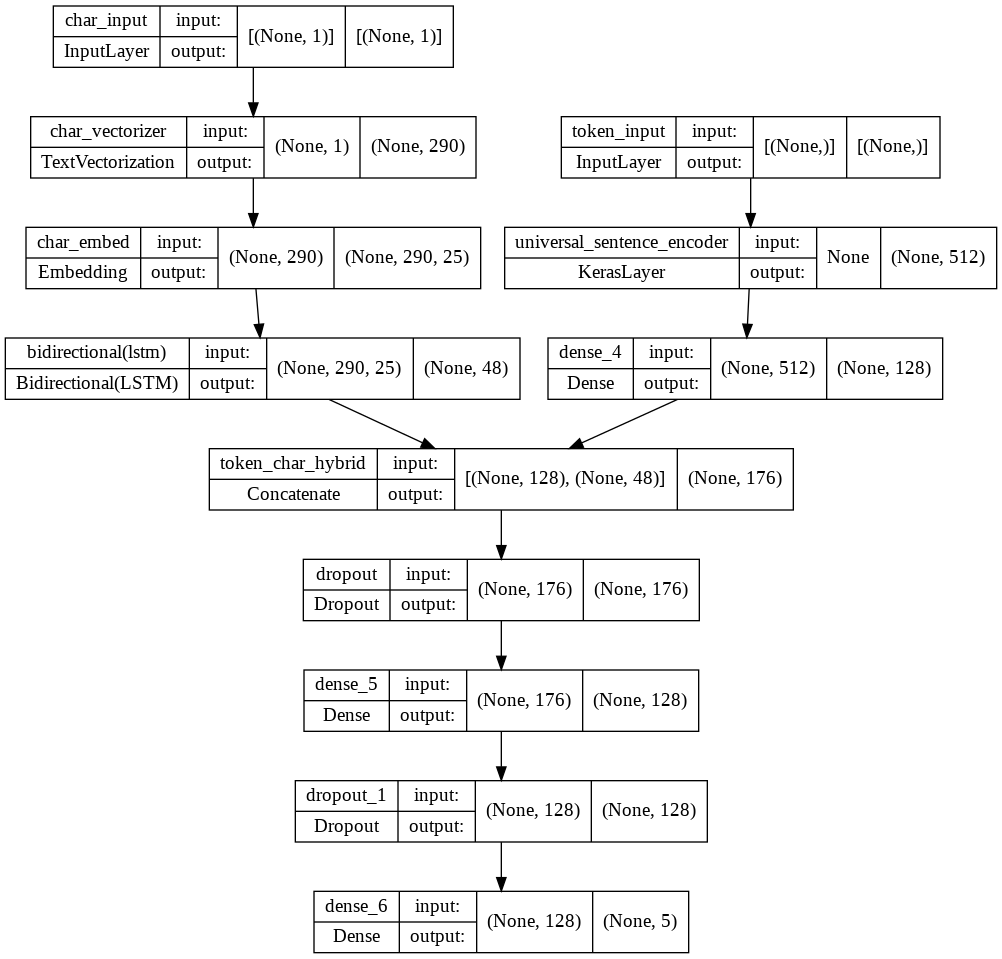

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4 , show_shapes = True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

### Combining token and character data into tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars)) # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels)) # COmbine data and labels

# Prefetch and batch train data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 50ms/step - loss: 0.9756 - accuracy: 0.6104 - val_loss: 0.7805 - val_accuracy: 0.7055
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7993 - accuracy: 0.6883 - val_loss: 0.7138 - val_accuracy: 0.7254
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7813 - accuracy: 0.7026 - val_loss: 0.6940 - val_accuracy: 0.7364


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.6950 - accuracy: 0.7356


[0.6949586272239685, 0.7356348633766174]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.7272736e-01, 4.0920705e-01, 4.6908148e-03, 2.0623997e-01,
        7.1348427e-03],
       [2.7876267e-01, 5.4888511e-01, 5.1393211e-03, 1.6443066e-01,
        2.7823064e-03],
       [2.7979210e-01, 1.8764378e-01, 5.3584423e-02, 4.2793670e-01,
        5.1043019e-02],
       ...,
       [5.9064571e-04, 7.5244121e-03, 5.4374427e-02, 2.6830920e-04,
        9.3724215e-01],
       [7.3475651e-03, 6.2037684e-02, 2.3761719e-01, 2.9051274e-03,
        6.9009244e-01],
       [2.4554139e-01, 4.3925825e-01, 2.0994708e-01, 3.8615722e-02,
        6.6637613e-02]], dtype=float32)

In [ ]:
# Convert to labels
model_4_preds = tf.argmax(model_4_pred_probs,axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_char_token_embedding_results = calculate_results(val_labels_encoded,
                                                         model_4_preds)

In [ ]:
model_4_char_token_embedding_results

{'accuracy': 73.56348470806302,
 'f1': 0.7323396901603724,
 'precision': 0.7387754773009445,
 'recall': 0.7356348470806302}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be availabel at the testing time. In our case line numbers and total lines are availabel

### Creating positional embedding

In [ ]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

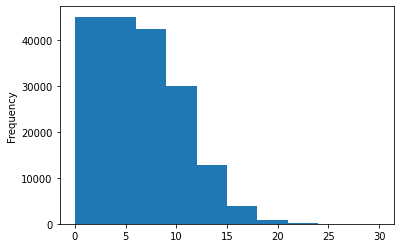

In [ ]:
# Check the distribution of line numbers column
train_df.line_number.plot.hist()

In [ ]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth = 15)
train_line_numbers_one_hot[:14] , train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth = 15)


Now we've encoded our line numbers feature , let's do the same for our total lines

In [ ]:
# How many different number of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

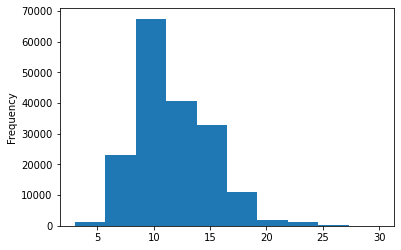

In [ ]:
# Plot the distributions
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_lines"
np.percentile(train_df.total_lines,98.5)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of "total_line"
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(),depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(),depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(),depth = 20)
train_total_lines_one_hot[:14] , train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level Model
2. Create a character-level Model
3. Create a model for the "line_number" feature
4. Creae a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilties
8. Combine the inputus of 1 ,2 ,3,4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape = [],dtype = "string",name= "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs ,
                             token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,),dtype = "string",name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs , 
                            char_bi_lstm)

# 3. Line number model
line_number_inputs = layers.Input(shape = (15 , ),dtype = tf.float32 , name = "line_number_input")
x = layers.Dense(32 , activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,) ,dtype = tf.float32 , name = "total_lines_input")
y = layers.Dense(32,activation = "relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs,
                                  y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hyrid_embeddings")([token_model.output,
                                                                                char_model.output])
z = layers.Dense(256 , activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_postional_embedding")([line_number_model.output,
                                                                                  total_line_model.output,
                                                                                  z])

# 7. Create output layer
output_layer = layers.Dense(num_classes,activation = "softmax",name = "output_layer")(tribrid_embeddings)

# 8. Put together model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_line_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "model_5")

In [ ]:
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

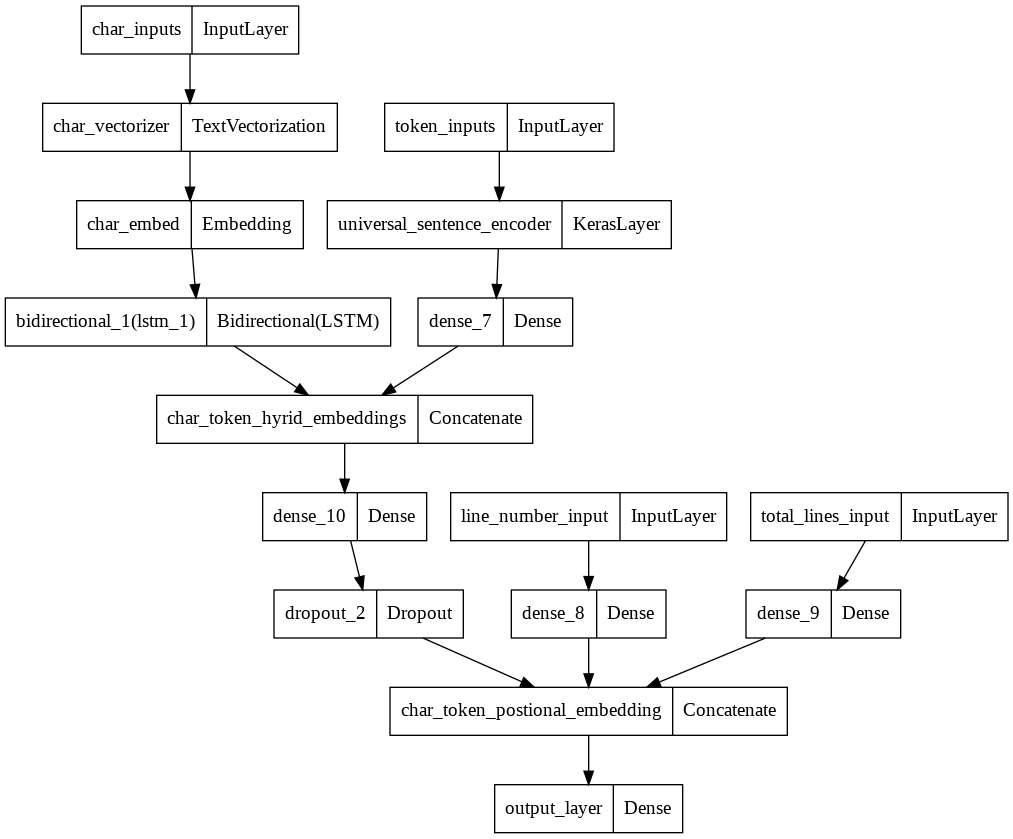

In [ ]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Compile the model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # to reduce overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Create tribrid embedding dataset using tf.data


In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation set
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# For test
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset , val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting,evaluating and making predictions with our tribrid model

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs = 5,
                              steps_per_epoch = len(train_char_token_pos_dataset),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
5627/5627 [==============================] - 250s 44ms/step - loss: 0.9236 - accuracy: 0.8438 - val_loss: 0.9072 - val_accuracy: 0.8527
Epoch 2/5
5627/5627 [==============================] - 251s 45ms/step - loss: 0.9034 - accuracy: 0.8577 - val_loss: 0.9033 - val_accuracy: 0.8514
Epoch 3/5
5627/5627 [==============================] - 250s 44ms/step - loss: 0.8927 - accuracy: 0.8662 - val_loss: 0.9002 - val_accuracy: 0.8531
Epoch 4/5
5627/5627 [==============================] - 249s 44ms/step - loss: 0.8848 - accuracy: 0.8711 - val_loss: 0.8995 - val_accuracy: 0.8501
Epoch 5/5
5627/5627 [==============================] - 242s 43ms/step - loss: 0.8784 - accuracy: 0.8765 - val_loss: 0.9029 - val_accuracy: 0.8494


In [ ]:
# Make prediction
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset , verbose = 1)

945/945 [==============================] - 20s 21ms/step


In [ ]:
# COnvert pred probs to pred labels
model_5_preds= tf.argmax(model_5_pred_probs ,axis = 1)

In [ ]:
# Calculate the results
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)

In [ ]:
model_5_results

{'accuracy': 85.52230901628492,
 'f1': 0.8528136993646744,
 'precision': 0.8565758653538714,
 'recall': 0.8552230901628493}

In [ ]:
model_4_char_token_embedding_results 

{'accuracy': 73.56348470806302,
 'f1': 0.7323396901603724,
 'precision': 0.7387754773009445,
 'recall': 0.7356348470806302}

## Compare model results

In [ ]:
# Combine the model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline":baseline_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_char_token_embedding_results,
                                  "model_5_pos_char_token_embedding":model_5_results})

In [ ]:
all_model_results = all_model_results.transpose()

In [ ]:
# Reduce the accuarcy to same scale
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.785549,0.782569,0.785549,0.783339
model_2_pretrained_token_embedding,0.714451,0.714551,0.714451,0.711565
model_3_custom_char_embedding,0.662320,0.655008,0.662320,0.652566
model_4_hybrid_char_token_embedding,0.735635,0.738775,0.735635,0.732340
model_5_pos_char_token_embedding,0.855223,0.856576,0.855223,0.852814


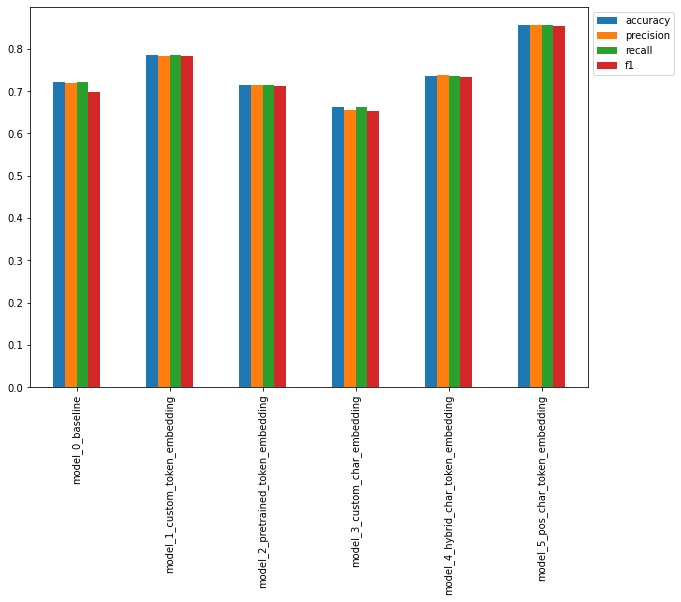

In [ ]:
# Plot and comapre all model results
all_model_results.plot(kind = "bar" , figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0));

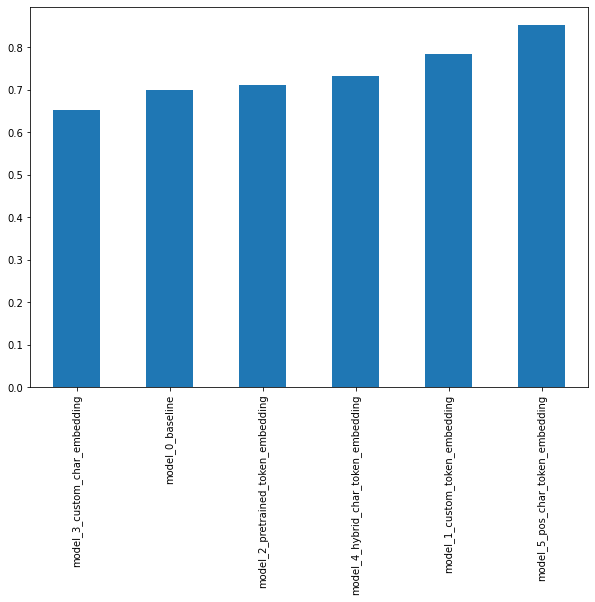

In [ ]:
# Sort the model by f1-score
all_model_results.sort_values("f1",ascending = True)["f1"].plot(kind = "bar" , figsize = (10,7));

## Save and load the model

In [ ]:
# Save the best performing model to SavedModel format(default)
# model_5.save("/content/drive/MyDrive/skimlit_tribrid_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/skimlit_tribrid_model/assets


In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/skimlit_tribrid_model")

In [ ]:
# Make prediction with the loaded model
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs,axis = 1)
loaded_model_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_model_preds)
loaded_model_results

{'accuracy': 85.52230901628492,
 'f1': 0.8528136993646744,
 'precision': 0.8565758653538714,
 'recall': 0.8552230901628493}

In [ ]:
assert model_5_results == loaded_model_results

## Evaluate the model on Test data

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/skimlit_tribrid_model")

In [ ]:
# Create test dataset and prefetch
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data , test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = model.predict(test_char_token_pos_dataset, verbose = 1)
test_preds = tf.argmax(test_pred_probs ,axis = 1)


942/942 [==============================] - 30s 24ms/step


In [ ]:
from helper_function import calculate_results
test_results = calculate_results(test_labels_encoded,
                                 test_preds)

In [ ]:
test_results

{'accuracy': 85.14683922349427,
 'f1': 0.8489160550865285,
 'precision': 0.85173066840693,
 'recall': 0.8514683922349428}

## Finding most wrong predictions

In [ ]:
%%time
# Get the list of class names of the test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

CPU times: user 11.6 s, sys: 1.17 s, total: 12.8 s
Wall time: 10.9 s


In [ ]:
test_pred_classes

In [ ]:
# Create prediction encriched dataframe
test_df["prediction"] = test_pred_classes # Create column with test prediction class name
test_df["pred_prob"] = tf.reduce_max(test_pred_probs , axis = 1).numpy() # get the maximum prediction probabilities
test_df["correct"] = test_df["prediction"] == test_df["target"]

In [ ]:
test_df.head(14)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.384145,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.371765,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.794142,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.844021,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.721244,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.851039,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.773991,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.679488,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.610131,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.667362,True


In [ ]:
# Find the top 100 wrong predictions
top_100_wrong = test_df[test_df["correct"]==False].sort_values("pred_prob",ascending = False)[:100]

In [ ]:
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
22736,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.946957,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.939218,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.936717,False
6856,OBJECTIVE,there are currently no therapies to prevent or...,2,16,BACKGROUND,0.933010,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.930150,False
...,...,...,...,...,...,...,...
12158,METHODS,"in the saffron group , there was no decline in...",9,12,RESULTS,0.856893,False
13693,METHODS,sixty patients completed the study .,8,13,RESULTS,0.856860,False
4350,CONCLUSIONS,"also , heart failure hospitalization was more ...",11,11,RESULTS,0.856713,False
21180,OBJECTIVE,in patients undergoing bilateral tibial length...,2,17,METHODS,0.856538,False


In [ ]:
# Investigate the wrong predictions
for row in top_100_wrong.itertuples():
  _,target ,text , line_number , total_lines , prediction , pred_prob , _ = row
  print(f"Target:{target} , Pred:{prediction} , Prob:{pred_prob} , line_number:{line_number} , Total_lines:{total_lines}")
  print(f"Text:\n{text}\n")
  print("-----------------------------------------------------------------------------\n")

Target:OBJECTIVE , Pred:METHODS , Prob:0.9469574093818665 , line_number:4 , Total_lines:20
Text:
the national institute of oncology , budapest conducted a single centre randomized clinical study .

-----------------------------------------------------------------------------

Target:METHODS , Pred:BACKGROUND , Prob:0.9392178058624268 , line_number:1 , Total_lines:11
Text:
pretest-posttest .

-----------------------------------------------------------------------------

Target:CONCLUSIONS , Pred:BACKGROUND , Prob:0.9367167949676514 , line_number:18 , Total_lines:18
Text:
nct@ ( clinicaltrials.gov ) .

-----------------------------------------------------------------------------

Target:OBJECTIVE , Pred:BACKGROUND , Prob:0.9330095648765564 , line_number:2 , Total_lines:16
Text:
there are currently no therapies to prevent or treat bk virus infection .

-----------------------------------------------------------------------------

Target:METHODS , Pred:RESULTS , Prob:0.9301499724388123 , l

## Making example perdictions on custom examples

Since the abstract we are going to use aren't the same format that the model is trained on, so we need to preprocess the data.

Therefore for each abstract we need to :
1. Split it into sentences (lines).
2. Split it into characters.
3. Find the number of each line.
4. Find the total number of lines.

In [ ]:
# Download the abstract
import json 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts[0]

--2022-07-01 06:43:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.2’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-07-01 06:43:14 (72.8 MB/s) - ‘skimlit_example_abstracts.json.2’ saved [6737/6737]



{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 'details': 'RCT of a manualized social treatment for high-functioning autism spectrum di

In [ ]:
example_abstracts[1]

{'abstract': "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of matern

In [ ]:
# See the example
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
def create_sentencizer(name,index):
  """ 
  Create sentencizer 
  """
  from spacy.lang.en import English
  nlp = English() # setup English sentence parser
  sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
  nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
  doc = nlp(name[index]) # create "doc" of parsed sequences, change index for a different abstract
  abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
  return abstract_lines

In [ ]:
list(example_abstracts[1].keys())[0]

'abstract'

In [ ]:
abstract_lines = create_sentencizer(example_abstracts[0] , list(example_abstracts[0].keys())[0])

In [ ]:
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines = len(abstract_lines)

# Preprocessing it like our training data
sample_lines=[]

for i , line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines - 1
  sample_lines.append(sample_dict)

sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
# One hot encode the line numbers
test_line_numbers = [line["line_number"] for line in sample_lines]

test_line_number_one_hot = tf.one_hot(test_line_numbers , depth = 15)

In [ ]:
# One hot total lines
test_total_lines = [line["total_lines"] for line in sample_lines]
test_total_lines_one_hot = tf.one_hot(test_total_lines , depth = 20)

In [ ]:
# Splir abstract lines into character
test_chars = [split_chars(sentence) for sentence in abstract_lines]
test_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = model.predict(x=(test_line_number_one_hot,
                                                   test_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(test_chars)))
test_abstract_pred_probs

CPU times: user 2.57 s, sys: 38.4 ms, total: 2.61 s
Wall time: 2.6 s


In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 2, 2, 1, 4, 4, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
CONCLUSIONS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
